## Good Resources

#### https://www.kaggle.com/code/prashant111/explain-your-model-predictions-with-shapley-values/notebook
#### https://towardsdatascience.com/explain-nlp-models-with-lime-shap-5c5a9f84d59b
#### https://medium.com/nlplanet/two-minutes-nlp-explain-predictions-with-shap-values-2a0e34219177

In [1]:
#Read in the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df1=pd.read_csv("https://raw.githubusercontent.com/statzenthusiast921/political-emails-analysis/main/main/data/clean_emails_df1.csv")
df2=pd.read_csv("https://raw.githubusercontent.com/statzenthusiast921/political-emails-analysis/main/main/data/clean_emails_df2.csv")
df3=pd.read_csv("https://raw.githubusercontent.com/statzenthusiast921/political-emails-analysis/main/main/data/clean_emails_df3.csv")
df4=pd.read_csv("https://raw.githubusercontent.com/statzenthusiast921/political-emails-analysis/main/main/data/clean_emails_df4.csv")

print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)

(19000, 20)
(19000, 20)
(19000, 20)
(17148, 20)


In [2]:
#Stack 4 dataframes together
df = pd.concat([df1, df2, df3, df4], ignore_index=True, axis=0)
#Delete first row and column
df = df[1:]
df = df.iloc[: , 1:]
#Preview dataframe
df.head(2)

,subject,date,body,party,country,locality,office,time,AM_PM,Hour,Hour_Mil,month,day,year,month_num,cleaned_body,sentiment,compound,comp_score
1,TAKE ACTION for Freedom: #CloseTheCamps,"July 3, 2019","Dear friend, We have all seen the images and r...",NaN,United States,NaN,NaN,11:31 PM,PM,11,23,July,3,2019,7,dear friend seen images read stories migrants ...,"{'neg': 0.207, 'neu': 0.674, 'pos': 0.12, 'com...",-0.9807,0
2,trauma-informed schools,"July 3, 2019","Team,Access to education is fundamental to a c...",Democratic,United States,Ohio,President of the United States,11:32 PM,PM,11,23,July,3,2019,7,team access education fundamental child succes...,"{'neg': 0.143, 'neu': 0.658, 'pos': 0.199, 'co...",0.7269,1


In [3]:
df = df[df['year']>1970]
import numpy as np
df['locality'] = np.where(df['locality']=="MIchigan","Michigan",df['locality'])

### SHAP values are about local interpretability of a predictive model, i.e. they explain how each feature influenced the single predictions.

In [4]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import shap
from sklearn.ensemble import RandomForestClassifier

/Users/jonzimmerman/Desktop/Data Projects/Political Emails/main/notebooks/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
X = df['cleaned_body'].values.astype('U').tolist()
y = df['comp_score'].to_numpy()

In [6]:
print(type(y))
print(type(X))

<class 'numpy.ndarray'>
<class 'list'>


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7, stratify=y)

In [8]:
print(type(X_train))
print(type(y_train))
print(type(X_test))
print(type(y_test))

<class 'list'>
<class 'numpy.ndarray'>
<class 'list'>
<class 'numpy.ndarray'>


In [9]:
#This is where the problem is
vectorizer = TfidfVectorizer(min_df=10)
X_train_vec = vectorizer.fit_transform(X_train).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()

model = RandomForestClassifier()
model.fit(X_train_vec, y_train)

RandomForestClassifier()

#### In this step, we create an Explainer object with the model and the training data, so that it can retrain it if necessary. The Explainer object is then used to compute the SHAP values of the features (i.e. the single words of the reviews) using the test set. This step might take a while.

In [10]:
feature_names = vectorizer.get_feature_names_out()
explainer = shap.Explainer(model, X_train_vec, feature_names=feature_names)
shap_values = explainer(X_test_vec)
print(shap_values.values.shape) # (14830, 30613, 2)

100%|===================| 29655/29660 [96:05<00:00]        

(14830, 30613, 2)


#### Eventually, we can plot the SHAP values of the features for each prediction. Let’s consider a positive review now.

In [78]:
#Let's find positive/negative emails for both Democratic/Republican classes

#1.) Negative Republican Email
text1 = X_test[1]

#2.) Positive Republican Email
text2 = X_test[16]

#3.) Positive Democratic Email
text3 = X_test[2]

#4.) Negative Democratic Email
text4 = X_test[35]


daines senate need fight back take back seat democrats attempt destroy president trump overturn american people joined lindsey graham today condemning closed door illegitimate impeachment inquiry lead nancy pelosi house democrats want receive emails unsubscribe friend need stop witch hunt nancy pelosi radical democrats obsessed impeachment sham denying concerned impeaching president trump working american people jobs friend want stop left impeachment obsession need keep republicans control senate starts right race montana whyi need immediate help need fight back take back seat democrats attempt destroy president trump overturn american people joined lindsey graham condemning closed door illegitimate impeachment inquiry led nancy pelosi house democrats need join us fight put end left impeachment obsession time get back work friend wait put end sham thanks senator steve daines steve daines fifth generation montanan life long sportsman father four serving people montana senator steve comm

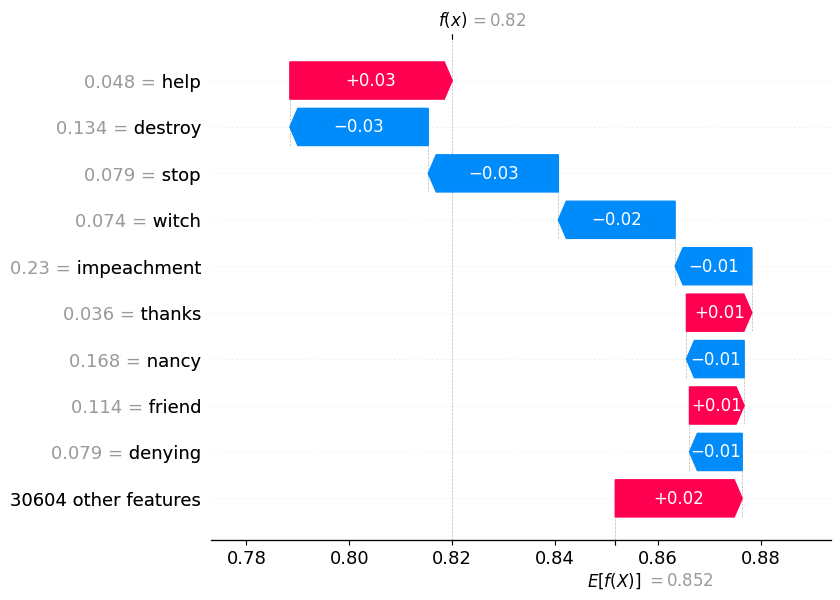

In [79]:
#Negative Republican Email Example
shap.initjs()

ind = 1
print(X_test[ind])
shap.plots.waterfall(shap_values[ind,:,1])

In [ ]:
#Average model prediction shifts from 0.852 overall to 0.82 for this specific sample 
#the words "help" and "destory" had the most to do with it

john feels like practically every time reach share bad news another gop party boss kowtowing trump disenfranchising voters like saw yesterday state georgia president putting cronies financial interests american farmers industry disrespecting intelligence community damaging country reputation world stage well today writing good news got word tennessee republican secretary state rejected pressure trump cult keep viable republican primary challengers like joe ballot means unlike nearly dozen states state party bosses succeeded disenfranchising voters tennessee voters able go polls support joe super tuesday john really believe another sign making progress finally getting republicans power waking everyday american voters like us feel much need course correction starting listen bravery supporters like enabling brave standing trump another series ballot access deadlines looming next weeks faith momentum side help us keep momentum going whatever give even bucks less difference getting joe mess

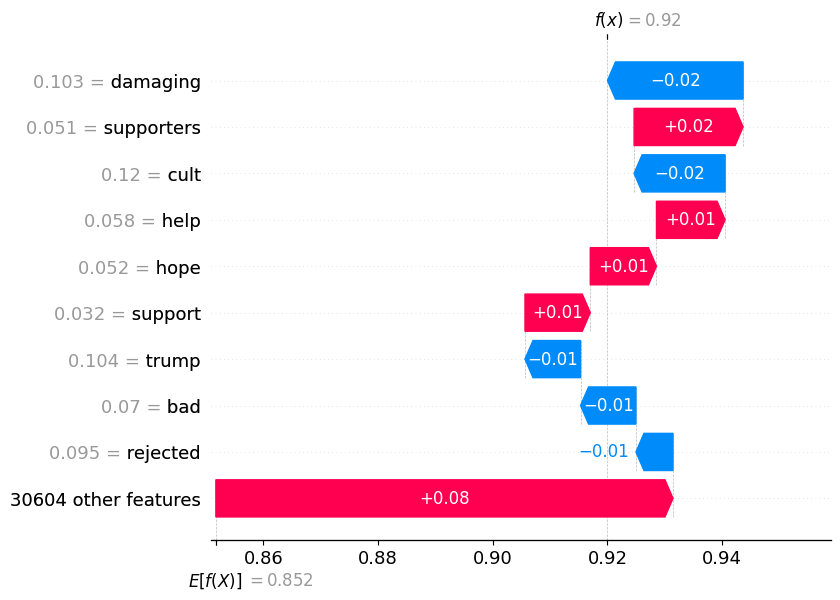

In [80]:
#Positive Republican Email
shap.initjs()

ind = 16
print(X_test[ind])
shap.plots.waterfall(shap_values[ind,:,1])

john feels like practically every time reach share bad news another gop party boss kowtowing trump disenfranchising voters like saw yesterday state georgia president putting cronies financial interests american farmers industry disrespecting intelligence community damaging country reputation world stage well today writing good news got word tennessee republican secretary state rejected pressure trump cult keep viable republican primary challengers like joe ballot means unlike nearly dozen states state party bosses succeeded disenfranchising voters tennessee voters able go polls support joe super tuesday john really believe another sign making progress finally getting republicans power waking everyday american voters like us feel much need course correction starting listen bravery supporters like enabling brave standing trump another series ballot access deadlines looming next weeks faith momentum side help us keep momentum going whatever give even bucks less difference getting joe mess

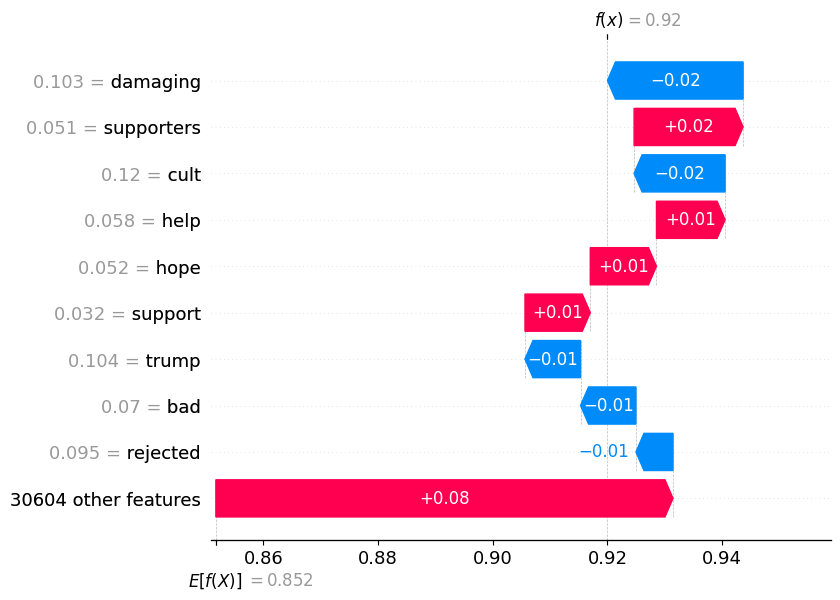

In [89]:
#Positive Democratic Email
shap.initjs()

ind = 16
print(X_test[ind])
shap.plots.waterfall(shap_values[ind,:,1])

furious congress pushes investigate donald trump abuse presidential power continued launching vicious unfounded attacks campaign even said republican ever joe biden getting electric chair fight back hard best chance defeat donald trump unfortunately checked donated joe biden worry still time public fundraising deadline official biden hq record name fileemail date last contribution n next steps make first contribution elect joe biden critical september deadline days raise joe biden important important election lifetime let slip fingers need help september deadline


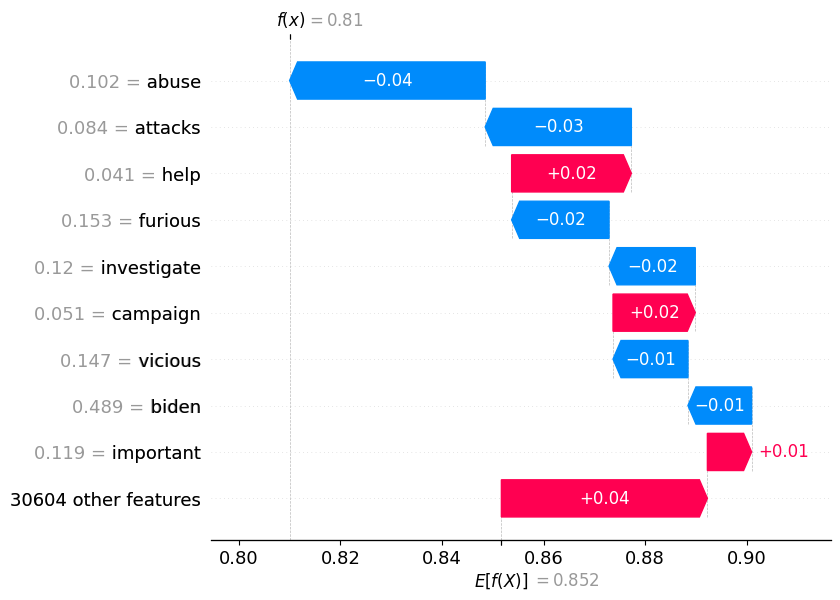

In [85]:
#Negative Democratic Email
shap.initjs()

ind = 35
print(X_test[ind])
shap.plots.waterfall(shap_values[ind,:,1])

#### Each point in the plot below represents the word “war” in a different sample of the test set. Its x-coordinate represents the TF-IDF value of the specific sample, while the y-coordinate represents its SHAP value.

#### Almost every time the word “war” is present in a sample (i.e. when its TF-IDF score is greater than zero), it contributes to a shift of the prediction towards the negative label.

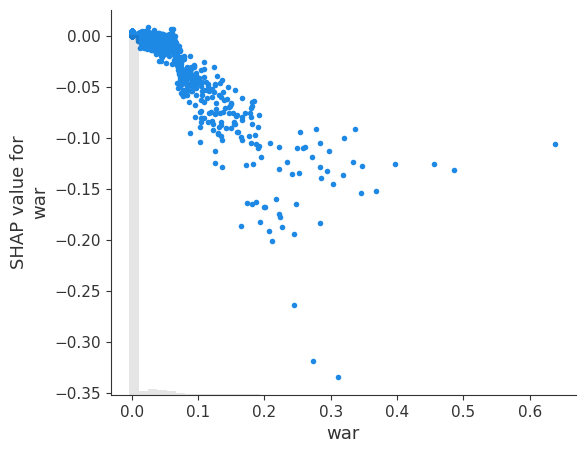

In [83]:
shap.plots.scatter(shap_values[:,feature_names.tolist().index("war"),1])

#### This chart is not as clear as the previous.  Each time the word “please” is present in a sample (i.e. when its TF-IDF score is greater than zero), it contributes to a a slight shift of the prediction towards the positive label, but not by a lot.

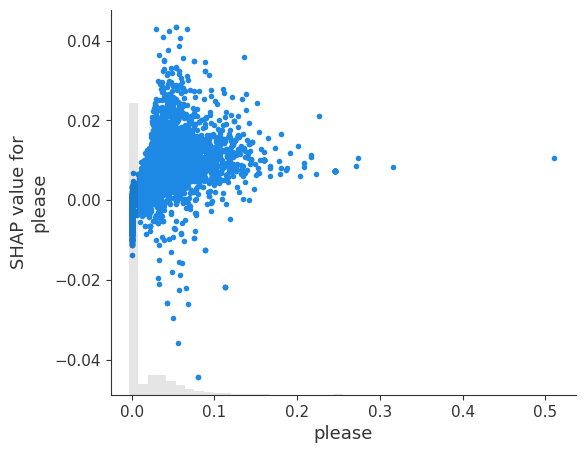

In [98]:
shap.plots.scatter(shap_values[:,feature_names.tolist().index("please"),1])


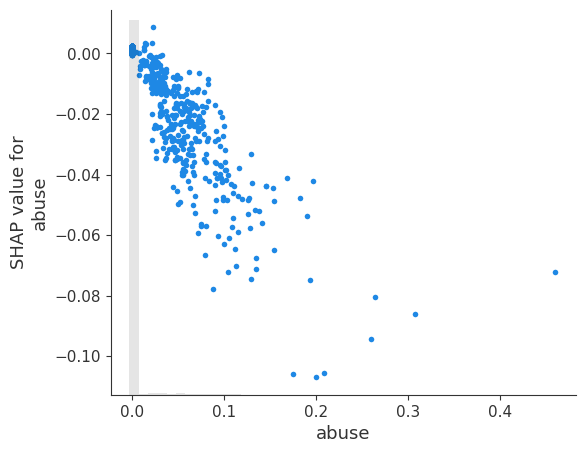

In [86]:
shap.plots.scatter(shap_values[:,feature_names.tolist().index("abuse"),1])
